<a href="https://colab.research.google.com/github/KJanzon/project-nlp-challenge/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Fake News

Task:
- Train the model on training data set.
- Validate model on training data set.
- Predict real/fake news on 'testing_data' data set.
-- label: 0 if the news is fake, 1 if the news is real.


Steps:

- Load data from google drive
- Data pre-processing
-- data cleaning
-- stop words removal

- Train/Validation split (on training data set)
- Plot validation result
-- training/validation loss
-- training/validation accuracy






In [57]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
# Download NLTK datasets
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [38]:
from google.colab import drive
import os

drive.mount('/content/drive')


# Define paths to the CSV files
training_data_path = "/content/drive/My Drive/training_data_lowercase.csv"
testing_data_path = "/content/drive/My Drive/testing_data_lowercase_nolabels.csv"


# Load datasets
train_df = pd.read_csv(training_data_path, sep='\t', header=None, names=['label', 'text'])
test_df = pd.read_csv(testing_data_path, sep='\t', header=None, names=['label','text'])

# Display first few rows
print("Training Data Sample:")
print(train_df.head())

print("\nTesting Data Sample:")
print(test_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Data Sample:
   label                                               text
0      0  donald trump sends out embarrassing new year‚s...
1      0  drunk bragging trump staffer started russian c...
2      0  sheriff david clarke becomes an internet joke ...
3      0  trump is so obsessed he even has obama‚s name ...
4      0  pope francis just called out donald trump duri...

Testing Data Sample:
  label                                               text
0     2  copycat muslim terrorist arrested with assault...
1     2  wow! chicago protester caught on camera admits...
2     2   germany's fdp look to fill schaeuble's big shoes
3     2  mi school sends welcome back packet warning ki...
4     2  u.n. seeks 'massive' aid boost amid rohingya '...


In [39]:
# Check for missing values
print("Missing values in training data:")
print(train_df.isnull().sum())

print("\nMissing values in testing data:")
print(test_df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows in training data:", train_df.duplicated().sum())
print("Number of duplicate rows in testing data:", test_df.duplicated().sum())

# Display column names
print("\nTraining Data Columns:", train_df.columns)
print("Testing Data Columns:", test_df.columns)


Missing values in training data:
label    0
text     0
dtype: int64

Missing values in testing data:
label    0
text     0
dtype: int64

Number of duplicate rows in training data: 1946
Number of duplicate rows in testing data: 775

Training Data Columns: Index(['label', 'text'], dtype='object')
Testing Data Columns: Index(['label', 'text'], dtype='object')


In [40]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()
test_df = test_df.drop_duplicates()

# Drop missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

# Ensure labels are integers
train_df['label'] = train_df['label'].astype(int)


Define Text Processing Functions


In [41]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()


def remove_stopwords(tokens):
    """Remove stopwords from a list of tokens."""
    return [word for word in tokens if word not in stopwords.words('english')]

def lemmatize_tokens(tokens):
    """Apply lemmatization to a list of tokens."""
    return [lemmatizer.lemmatize(word) for word in tokens]

def clean_text(text):
    """Clean and preprocess text by removing special characters, numbers, stopwords, and applying lemmatization."""
    text = str(text)  # Ensure it's a string
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\d+', ' ', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize
    tokens = remove_stopwords(tokens)  # Remove stopwords
    tokens = lemmatize_tokens(tokens)  # Apply lemmatization
    return ' '.join(tokens)

In [44]:
# Step 5: Apply Text Cleaning
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

# Step 6: Save Cleaned Data
train_df.to_csv("/content/training_data_cleaned.csv", index=False)
test_df.to_csv("/content/testing_data_cleaned.csv", index=False)

In [32]:
# Ensure labels are integers
train_df['label'] = train_df['label'].astype(int)

# Check class distribution
print(train_df['label'].value_counts())


label
1    16181
0    16025
Name: count, dtype: int64


#  Convert Text to Numerical Representation (TF-IDF)

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(train_df['cleaned_text'])
y = train_df['label']


#Split Data into Training and Validation Sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Train model

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [52]:
#Evaluate Model on Validation Data
y_pred = model.predict(X_val)
print("Model Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred))

Model Accuracy: 0.9298354548276933
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      3233
           1       0.92      0.94      0.93      3209

    accuracy                           0.93      6442
   macro avg       0.93      0.93      0.93      6442
weighted avg       0.93      0.93      0.93      6442



# Make predictions on test set

In [55]:
test_X = tfidf_vectorizer.transform(test_df['cleaned_text'])
test_df['label'] = model.predict(test_X)

# Step 11: Save Predictions
test_df.to_csv("/content/testing_data_predicted.csv", index=False)

print("Predictions saved successfully!")

Predictions saved successfully!


Visualization of Predictions


<ipython-input-58-812381b9ec13>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_df['label'], palette='coolwarm')


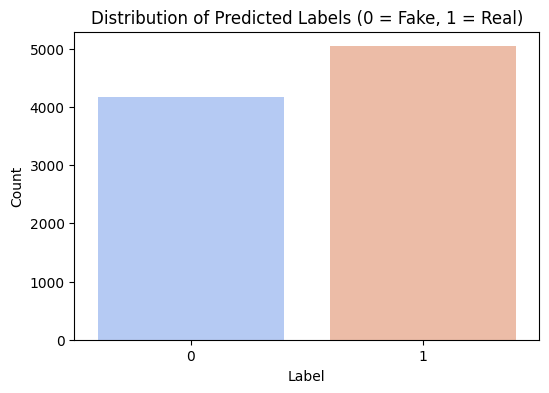

Sample Predictions:
                                                text  label
0  copycat muslim terrorist arrested with assault...      0
1  wow! chicago protester caught on camera admits...      0
2   germany's fdp look to fill schaeuble's big shoes      0
3  mi school sends welcome back packet warning ki...      0
4  u.n. seeks 'massive' aid boost amid rohingya '...      1
5  did oprah just leave ‚nasty‚ hillary wishing s...      0
6  france's macron says his job not 'cool' cites ...      1
7  flashback: chilling ‚60 minutes‚ interview wit...      0
8  spanish foreign ministry says to expel north k...      1
9  trump says cuba 'did some bad things' aimed at...      1


In [58]:


# Bar Chart of Label Distribution
plt.figure(figsize=(6,4))
sns.countplot(x=test_df['label'], palette='coolwarm')
plt.title("Distribution of Predicted Labels (0 = Fake, 1 = Real)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Display Sample Predictions
print("Sample Predictions:")
print(test_df[['text', 'label']].head(10))
